# Importation des packages et du Dataset

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR

In [8]:
df = pd.read_csv('football_ratings_cleaned.csv')
#df_avg = pd.read_csv('avg_football_ratings_cleaned.csv')

Choix du journal: 

    ['higher_rater','is_human']

Compétition:

    ['competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18']
    
Caractéristiques de jeux:

    ['flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute']

Nationnalité:

    ['English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team'] 

Caractéristiques Temporelles:

    ['year', 'semester']	

In [9]:
Y = df['original_rating'] # Continuous variable
X = df[[
    'higher_rater','is_human', #Raters
    
    'competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18', #Competitions

    'flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute', #Match
    
    'English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team', #Spatial dimension
    
    'year', 'semester']] #Temporal dimension

    -> Nous pourrions ajouter plus de variables de variable concernant les caractéristiques des joueurs en match mais serait lourd computationnellement pour une sensible amélioration du MSE, nous choisirons donc les variables les plus plus dépendantes à la note.

    -> Nous pourrions utiliser une méthode de réduction de dimension pour ces variables mais diminuerai l'intérêt d'utiliser des algorithmes capables de capturer les interactions entre variables.

**Elastic Net**

In [10]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle Elastic Net
elastic_net = ElasticNet(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'alpha': np.logspace(-4, 1, 10),  # Coefficient de régularisation global
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Équilibre entre L1 (Lasso) et L2 (Ridge)
}

# Configuration de la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_elastic_net = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred = best_elastic_net.predict(X_train)
y_test_pred = best_elastic_net.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Meilleurs hyperparamètres : {'alpha': 0.0001, 'l1_ratio': 0.9}
MSE sur l'ensemble d'entraînement : 0.6864
MSE sur l'ensemble de test : 0.6966


**Random Forest**

In [11]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest
rf = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [ 10, 20, 50, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [ 2, 4, 10],  
    'max_features': ['sqrt'],  
}

# Configuration de la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_rf = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs hyperparamètres : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MSE sur l'ensemble d'entraînement : 0.2777
MSE sur l'ensemble de test : 0.4475


**Boosting**

In [12]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ----- Gradient Boosting Regressor -----
gbr = GradientBoostingRegressor(random_state=42)
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_
print("Meilleurs hyperparamètres pour Gradient Boosting :", grid_search_gbr.best_params_)

# ----- XGBoost -----
xgbr = xgb.XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10]
}
grid_search_xgb = GridSearchCV(xgbr, param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print("Meilleurs hyperparamètres pour XGBoost :", grid_search_xgb.best_params_)

# ----- LightGBM -----
lgbr = lgb.LGBMRegressor(random_state=42)
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}
grid_search_lgb = GridSearchCV(lgbr, param_grid_lgb, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_
print("Meilleurs hyperparamètres pour LightGBM :", grid_search_lgb.best_params_)

# ----- CatBoost -----
catboost = CatBoostRegressor(random_state=42, silent=True)
param_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 10]
}
grid_search_cat = GridSearchCV(catboost, param_grid_cat, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)
best_cat = grid_search_cat.best_estimator_
print("Meilleurs hyperparamètres pour CatBoost :", grid_search_cat.best_params_)

# ----- SVR -----
# svr = SVR()
# param_grid_svr = {
#     'kernel': ['linear', 'rbf'],
#     'C': [0.1, 1, 10],
#     'gamma': ['scale']
# }
# grid_search_svr = GridSearchCV(svr, param_grid_svr, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
# grid_search_svr.fit(X_train, y_train)
# best_svr = grid_search_svr.best_estimator_
# print("Meilleurs hyperparamètres pour SVR :", grid_search_svr.best_params_)

# ----- Evaluation des modèles -----
models = {
    "Gradient Boosting": best_gbr,
    "XGBoost": best_xgb,
    "LightGBM": best_lgb,
    "CatBoost": best_cat#,
    #"SVR": #best_svr
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - MSE Entraînement: {mse_train:.4f}, MSE Test: {mse_test:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 40521, number of used features: 17
[LightGBM] [Info] Start training from score 5.683642
Meilleurs hyperparamètres pour LightGBM : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimator

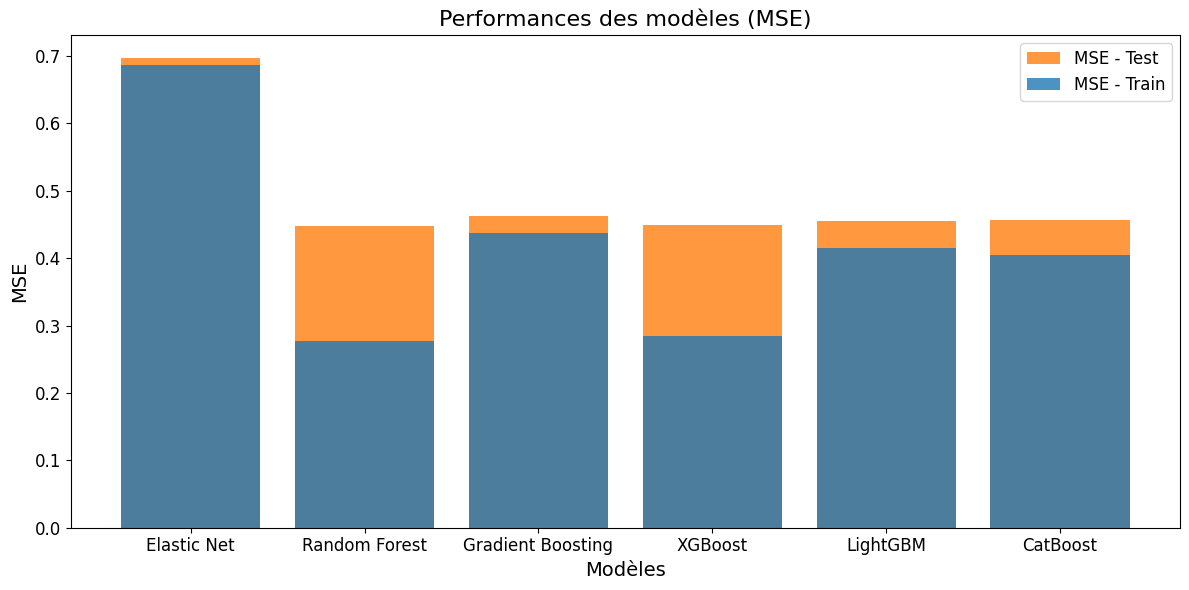

In [13]:
# Initialiser un dictionnaire pour stocker les performances des modèles
model_performance = {
    "Model": [],
    "Dataset": [],
    "MSE": []
}

# Fonction pour calculer et ajouter les performances au dictionnaire
def add_model_performance(model_name, model, X_train, y_train, X_test, y_test):
    """Calcule et ajoute les MSE des ensembles d'entraînement et de test."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Train")
    model_performance["MSE"].append(mse_train)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Test")
    model_performance["MSE"].append(mse_test)

# Ajouter les performances des modèles
add_model_performance("Elastic Net", best_elastic_net , X_train, y_train, X_test, y_test)
add_model_performance("Random Forest", best_rf, X_train, y_train, X_test, y_test)
add_model_performance("Gradient Boosting", best_gbr, X_train, y_train, X_test, y_test)
add_model_performance("XGBoost", best_xgb, X_train, y_train, X_test, y_test)
add_model_performance("LightGBM", best_lgb, X_train, y_train, X_test, y_test)
add_model_performance("CatBoost", best_cat, X_train, y_train, X_test, y_test)
#add_model_performance("SVM", best_svr, X_train, y_train, X_test, y_test)

# Convertir les performances en DataFrame
performance_df = pd.DataFrame(model_performance)

# Définir les couleurs pour les ensembles Train et Test
colors = {"Train": "#1f77b4", "Test": "#ff7f0e"}

# Générer un graphique à barres groupées pour les MSE
plt.figure(figsize=(12, 6))
for dataset in ["Test", "Train"]:
    subset = performance_df[performance_df["Dataset"] == dataset]
    plt.bar(subset["Model"], subset["MSE"], alpha=0.8, color=colors[dataset], label=f"MSE - {dataset}")

# Ajouter des détails au graphique
plt.title("Performances des modèles (MSE)", fontsize=16)
plt.ylabel("MSE", fontsize=14)
plt.xlabel("Modèles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
})
print(feature_importances.sort_values(by='Importance', ascending=False))

higher_rater: 2.7906
flow_centrality: 0.6658
is_human: -0.5650
goals: 0.3460
Substitute: -0.3268
win: 0.1258
English_Club: -0.0810
competition_Premier League 2017-18: 0.0575
German_Club: -0.0162
Rest_of_World_National_Team: 0.0123
semester: -0.0107
competition_Bundesliga 2017-18: -0.0042
European_National_Team: 0.0035
year: -0.0033
competition_World Cup 2018: -0.0028
minutesPlayed: -0.0004
nombre_apparitions: 0.0002


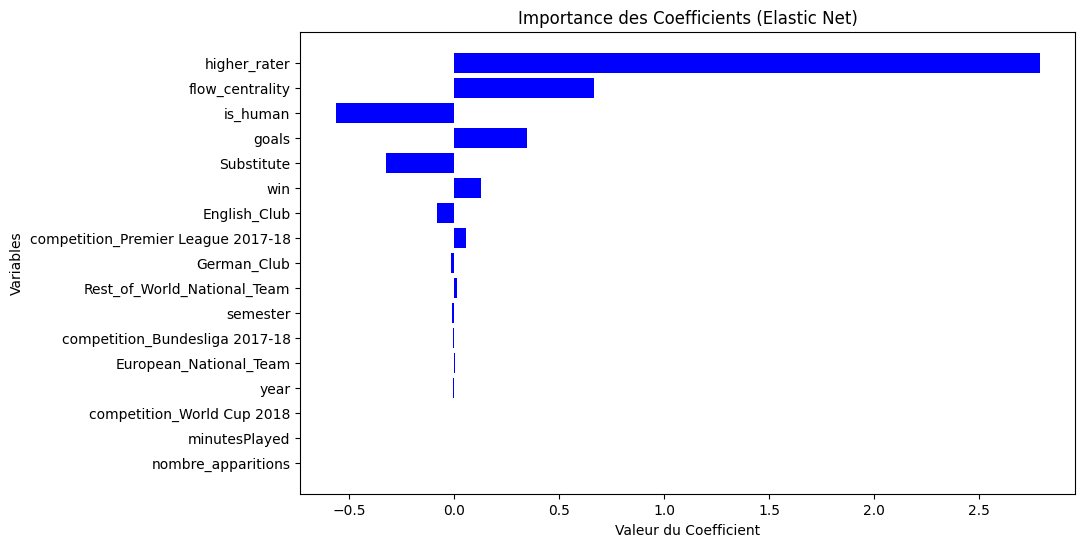

In [14]:
# Obtenir les coefficients du modèle Elastic Net optimisé
coefficients = best_elastic_net.coef_

# Afficher les coefficients avec les noms des variables
feature_names = X.columns  # Si X est un DataFrame Pandas, sinon remplace par une liste de noms
coef_dict = dict(zip(feature_names, coefficients))

# Trier et afficher les coefficients
sorted_coef = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")
    
# Extraire les noms et valeurs des coefficients triés
features, values = zip(*sorted_coef)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.barh(features, values, color="blue")
plt.xlabel("Valeur du Coefficient")
plt.ylabel("Variables")
plt.title("Importance des Coefficients (Elastic Net)")
plt.gca().invert_yaxis()  # Inverser l'ordre pour affichage lisible
plt.show()


In [15]:
# Initialiser un DataFrame pour stocker les importances des caractéristiques
all_feature_importances = pd.DataFrame()

# Fonction pour ajouter les importances au DataFrame global
def add_feature_importances(model_name, feature_importances, features):
    global all_feature_importances
    importance_df = pd.DataFrame({
        'Model': model_name,
        'Feature': features,
        'Importance': feature_importances
    })
    all_feature_importances = pd.concat([all_feature_importances, importance_df], ignore_index=True)

# Pour RF
add_feature_importances("Random Forest", best_rf.feature_importances_, X_train.columns)

# Ajouter les importances pour Gradient Boosting
add_feature_importances("Gradient Boosting", best_gbr.feature_importances_, X_train.columns)

# Ajouter les importances pour XGBoost
add_feature_importances("XGBoost", best_xgb.feature_importances_, X_train.columns)

# Ajouter les importances pour LightGBM
add_feature_importances("LightGBM", best_lgb.feature_importances_, X_train.columns)

# Ajouter les importances pour CatBoost
add_feature_importances("CatBoost", best_cat.feature_importances_, X_train.columns)

# Ajouter les importances pour SVR
#add_feature_importances("SVR", best_svr.feature_importances_, X_train.columns)

# Afficher les importances combinées
all_feature_importances = all_feature_importances.sort_values(by=['Model', 'Importance'], ascending=[True, False])
print(all_feature_importances) 

       Model                             Feature  Importance
68  CatBoost                        higher_rater   70.826940
75  CatBoost                                 win    6.644130
74  CatBoost                               goals    5.647746
69  CatBoost                            is_human    4.543909
73  CatBoost                     flow_centrality    3.261873
..       ...                                 ...         ...
47   XGBoost              European_National_Team    0.001630
38   XGBoost  competition_Premier League 2017-18    0.001157
37   XGBoost          competition_World Cup 2018    0.001087
36   XGBoost      competition_Bundesliga 2017-18    0.000996
46   XGBoost                         German_Club    0.000000

[85 rows x 3 columns]


C:\Users\valen\AppData\Local\Temp\ipykernel_20232\3141988659.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features = all_feature_importances.groupby("Model").apply(


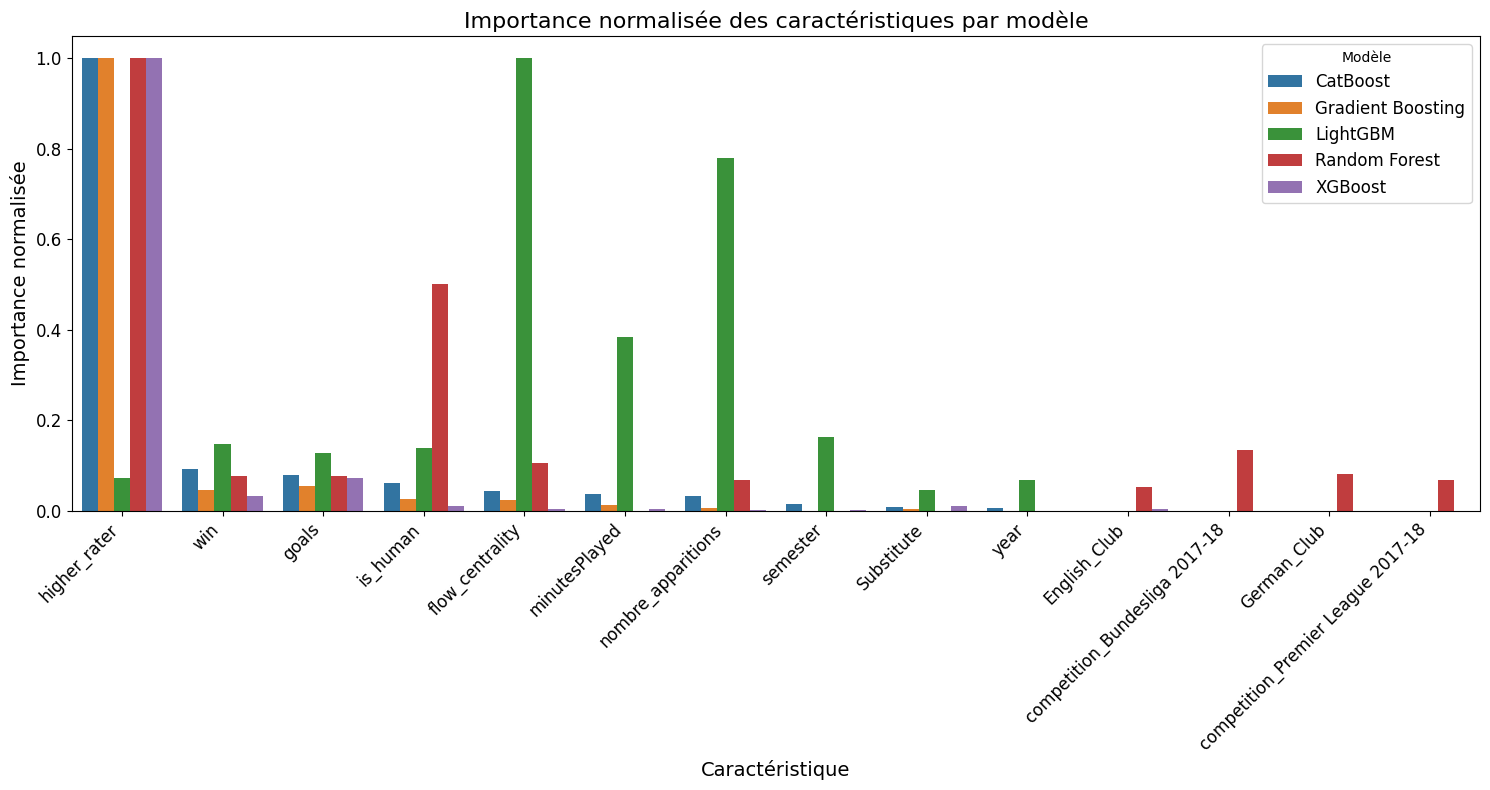

In [16]:
# Normalisation des importances (échelle 0-1) par modèle
all_feature_importances["Normalized Importance"] = all_feature_importances.groupby("Model")["Importance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Sélectionner les N caractéristiques les plus importantes pour chaque modèle
top_n = 10  # Modifier cette valeur pour afficher plus ou moins de caractéristiques
top_features = all_feature_importances.groupby("Model").apply(
    lambda x: x.nlargest(top_n, "Normalized Importance")
).reset_index(drop=True)

# Créer un graphique à barres groupées
plt.figure(figsize=(15, 8))
sns.barplot(
    data=top_features,
    x="Feature",
    y="Normalized Importance",
    hue="Model",
    dodge=True
)
plt.title("Importance normalisée des caractéristiques par modèle", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Caractéristique", fontsize=14)
plt.ylabel("Importance normalisée", fontsize=14)
plt.legend(title="Modèle", fontsize=12)
plt.tight_layout()
plt.show()

Au vu de la forte corrélation entre la note et le noteur, il n'est pas étonnant de voir que le 'higher_rater' apparait en première position pour les features importances.

Il est interessant de remarquer que le LightGBM se basera principalement sur des caractéristiques de terrain qui, à priori on un lien faible avec la note (cf. information mutuelle).

        -> Capture d'interactions entre variables

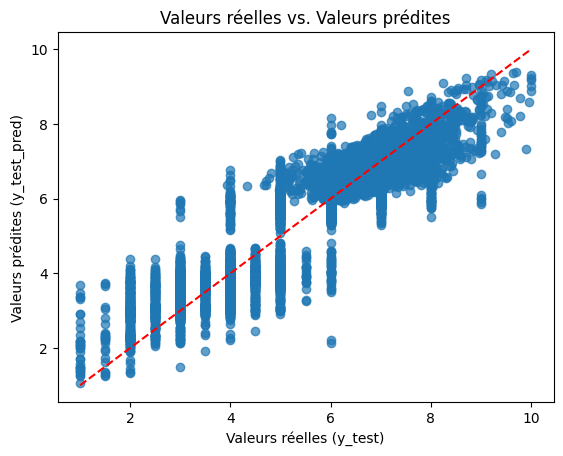

In [17]:
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.title("Valeurs réelles vs. Valeurs prédites")
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_test_pred)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

# En enlevant la discrimination par journal/bot ou non:

In [19]:
Y_reduce = df['original_rating'] #Variable continue
X_reduce = df[[
    'competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18',

    'flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute',
    
    'English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team',
    
    'year', 'semester']]


# Diviser les données en ensembles d'entraînement et de test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduce, Y_reduce, test_size=0.2, random_state=42)

In [20]:
# Initialiser le modèle Elastic Net
elastic_net2 = ElasticNet(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'alpha': np.logspace(-4, 1, 10),  # Coefficient de régularisation global
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Équilibre entre L1 (Lasso) et L2 (Ridge)
}

# Configuration de la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=elastic_net2,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search.fit(X_train2, y_train2)

# Meilleur modèle
best_elastic_net2 = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred2 = best_elastic_net2.predict(X_train2)
y_test_pred2 = best_elastic_net2.predict(X_test2)

mse_train = mean_squared_error(y_train2, y_train_pred2)
mse_test = mean_squared_error(y_test2, y_test_pred2)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Meilleurs hyperparamètres : {'alpha': 0.00035938136638046257, 'l1_ratio': 0.1}
MSE sur l'ensemble d'entraînement : 2.1848
MSE sur l'ensemble de test : 2.1738


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.892e+04, tolerance: 1.136e+01
  model = cd_fast.enet_coordinate_descent(


In [21]:
# Initialiser le modèle Random Forest
rf2 = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [ 10, 20, 50, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [ 2, 4, 10],  
    'max_features': ['sqrt'],  
}

# Configuration de la recherche sur grille avec validation croisée
grid_search2 = GridSearchCV(
    estimator=rf2,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search2.fit(X_train2, y_train2)

# Meilleur modèle
best_rf2 = grid_search2.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred2 = best_rf2.predict(X_train2)
y_test_pred2 = best_rf2.predict(X_test2)

mse_train = mean_squared_error(y_train2, y_train_pred2)
mse_test = mean_squared_error(y_test2, y_test_pred2)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs hyperparamètres : {'alpha': 0.00035938136638046257, 'l1_ratio': 0.1}
MSE sur l'ensemble d'entraînement : 1.9966
MSE sur l'ensemble de test : 2.0625


In [22]:
# ----- Gradient Boosting Regressor -----
gbr2 = GradientBoostingRegressor(random_state=42)
param_grid_gbr2 = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid_search_gbr2 = GridSearchCV(gbr2, param_grid_gbr2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_gbr2.fit(X_train2, y_train2)
best_gbr2 = grid_search_gbr2.best_estimator_
print("Meilleurs hyperparamètres pour Gradient Boosting :", grid_search_gbr2.best_params_)

# ----- XGBoost -----
xgbr2 = xgb.XGBRegressor(random_state=42)
param_grid_xgb2 = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10]
}
grid_search_xgb2 = GridSearchCV(xgbr2, param_grid_xgb2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_xgb2.fit(X_train2, y_train2)
best_xgb2 = grid_search_xgb2.best_estimator_
print("Meilleurs hyperparamètres pour XGBoost :", grid_search_xgb2.best_params_)

# ----- LightGBM -----
lgbr2 = lgb.LGBMRegressor(random_state=42)
param_grid_lgb2 = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}
grid_search_lgb2 = GridSearchCV(lgbr2, param_grid_lgb2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_lgb2.fit(X_train2, y_train2)
best_lgb2 = grid_search_lgb2.best_estimator_
print("Meilleurs hyperparamètres pour LightGBM :", grid_search_lgb2.best_params_)

# ----- CatBoost -----
catboost2 = CatBoostRegressor(random_state=42, silent=True)
param_grid_cat2 = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 10]
}
grid_search_cat2 = GridSearchCV(catboost2, param_grid_cat2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_cat2.fit(X_train2, y_train2)
best_cat2 = grid_search_cat2.best_estimator_
print("Meilleurs hyperparamètres pour CatBoost :", grid_search_cat2.best_params_)

# ----- SVR -----
# svr2 = SVR()
# param_grid_svr2 = {
#     'kernel': ['linear', 'rbf'],
#     'C': [0.1, 1, 10, 100],
#     'gamma': ['scale']
# }
# grid_search_svr2 = GridSearchCV(svr2, param_grid_svr2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
# grid_search_svr2.fit(X_train2, y_train2)
# best_svr2 = grid_search_svr2.best_estimator_
# print("Meilleurs hyperparamètres pour SVR :", grid_search_svr2.best_params_)

# ----- Evaluation des modèles -----
models2 = {
    "Gradient Boosting": best_gbr2,
    "XGBoost": best_xgb2,
    "LightGBM": best_lgb2,
    "CatBoost": best_cat2#,
    #"SVR": best_svr2
}

for name2, model2 in models2.items():
    y_train_pred2 = model2.predict(X_train2)
    y_test_pred2 = model2.predict(X_test2)
    mse_train2 = mean_squared_error(y_train2, y_train_pred2)
    mse_test2 = mean_squared_error(y_test2, y_test_pred2)
    print(f"{name2} - MSE Entraînement: {mse_train2:.4f}, MSE Test: {mse_test2:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 40521, number of used features: 15
[LightGBM] [Info] Start training from score 5.683642
Meilleurs hyperparamètres pour LightGBM : {'learning_rate': 0.01, 'max_depth': 10, 'n_estimator

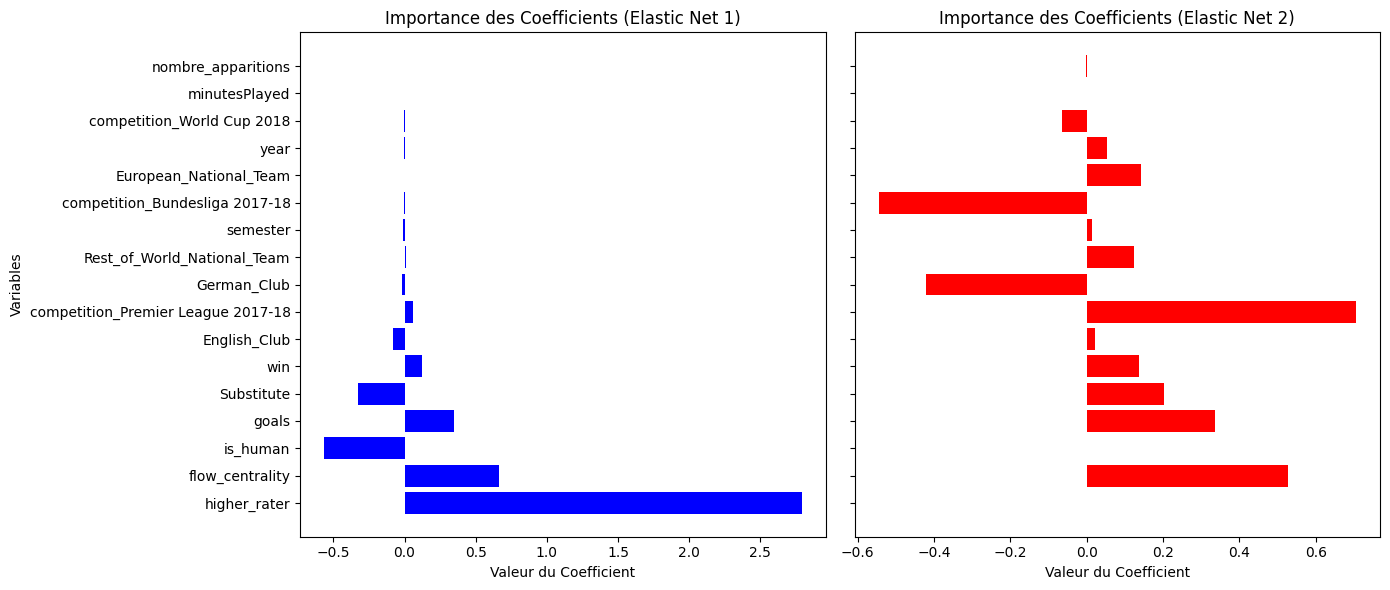

In [23]:
# Obtenir les coefficients des modèles Elastic Net optimisés
coefficients1 = best_elastic_net.coef_
coefficients2 = best_elastic_net2.coef_

# Afficher les coefficients avec les noms des variables
feature_names1 = X.columns  # Si X est un DataFrame Pandas, sinon remplace par une liste de noms
feature_names2 = X_reduce.columns

coef_dict1 = dict(zip(feature_names1, coefficients1))
coef_dict2 = dict(zip(feature_names2, coefficients2))

# Trier et afficher les coefficients pour chaque modèle
sorted_coef1 = sorted(coef_dict1.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_coef2 = sorted(coef_dict2.items(), key=lambda x: abs(x[1]), reverse=True)

# Extraire les noms et valeurs des coefficients triés
features1, values1 = zip(*sorted_coef1)
features2, values2 = zip(*sorted_coef2)

# Création du graphique comparatif
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Graphique Elastic Net 1
ax[0].barh(features1, values1, color="blue")
ax[0].set_xlabel("Valeur du Coefficient")
ax[0].set_ylabel("Variables")
ax[0].set_title("Importance des Coefficients (Elastic Net 1)")
ax[0].invert_yaxis()  # Inverser l'ordre pour affichage lisible

# Graphique Elastic Net 2
ax[1].barh(features2, values2, color="red")
ax[1].set_xlabel("Valeur du Coefficient")
ax[1].set_title("Importance des Coefficients (Elastic Net 2)")
ax[1].invert_yaxis()  # Inverser l'ordre pour affichage lisible

plt.tight_layout()
plt.show()


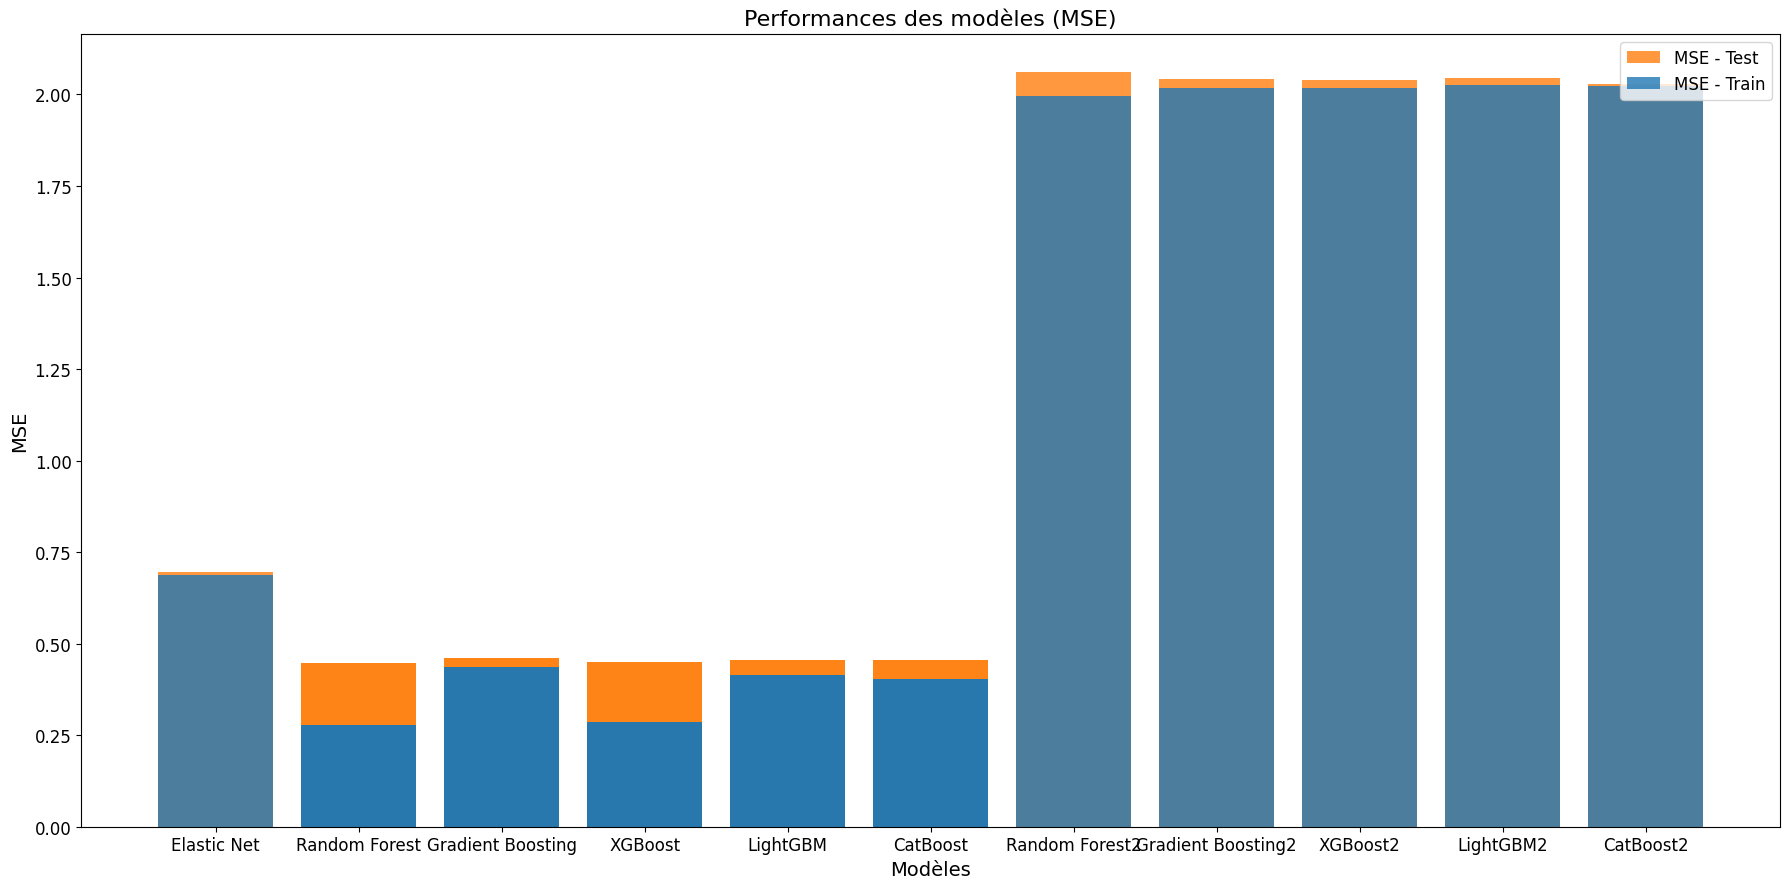

In [24]:
# Initialiser un dictionnaire pour stocker les performances des modèles
model_performance2 = {
    "Model": [],
    "Dataset": [],
    "MSE": []
}

# Fonction pour calculer et ajouter les performances au dictionnaire
def add_model_performance2(model_name, model, X_train2, y_train2, X_test2, y_test2):
    """Calcule et ajoute les MSE des ensembles d'entraînement et de test."""
    y_train_pred2 = model.predict(X_train2)
    y_test_pred2 = model.predict(X_test2)
    mse_train = mean_squared_error(y_train2, y_train_pred2)
    mse_test = mean_squared_error(y_test2, y_test_pred2)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Train")
    model_performance["MSE"].append(mse_train)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Test")
    model_performance["MSE"].append(mse_test)

# Ajouter les performances des modèles
add_model_performance("Random Forest", best_rf, X_train, y_train, X_test, y_test)
add_model_performance("Gradient Boosting", best_gbr, X_train, y_train, X_test, y_test)
add_model_performance("XGBoost", best_xgb, X_train, y_train, X_test, y_test)
add_model_performance("LightGBM", best_lgb, X_train, y_train, X_test, y_test)
add_model_performance("CatBoost", best_cat, X_train, y_train, X_test, y_test)
#add_model_performance("SVM", best_svr, X_train, y_train, X_test, y_test)


add_model_performance2("Random Forest2", best_rf2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("Gradient Boosting2", best_gbr2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("XGBoost2", best_xgb2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("LightGBM2", best_lgb2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("CatBoost2", best_cat2, X_train2, y_train2, X_test2, y_test2)
#add_model_performance2("SVM2", best_svr2, X_train2, y_train2, X_test2, y_test2)

# Convertir les performances en DataFrame
performance_df = pd.DataFrame(model_performance)

# Définir les couleurs pour les ensembles Train et Test
colors = {"Train": "#1f77b4", "Test": "#ff7f0e"}

# Générer un graphique à barres groupées pour les MSE
plt.figure(figsize=(18, 9))
for dataset in ["Test", "Train"]:
    subset = performance_df[performance_df["Dataset"] == dataset]
    plt.bar(subset["Model"], subset["MSE"], alpha=0.8, color=colors[dataset], label=f"MSE - {dataset}")

# Ajouter des détails au graphique
plt.title("Performances des modèles (MSE)", fontsize=16)
plt.ylabel("MSE", fontsize=14)
plt.xlabel("Modèles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

    -> Rôle important du noteur (car rapport à la note différente en fonction de la personne qui note).

    -> Distinction entre noteurs "discrets" et "continu" qui est difficile à capture si on n'a pas la variable "is_human"

    -> Pas fait dans ce script mais l'ajout de plus de variables concernant les performances des joueurs sur le terrain ne permet pas de mieux prédire les notes

# Questions (pour guider l'idée):

1-Qu’est-ce qui constitue la performance d’un « bon » joueur de football ?

2-Dans quelle mesure pouvons-nous prédire les notes attribuées aux performances des joueurs avec ces données ?

3-Dans quelle mesure le fait de regarder le football depuis une perspective réseau peut-il nous aider à comprendre les performances des joueurs ?

4-Quels attributs de la performance d’un joueur sont les plus valorisés par les algorithmes ?

5-Quels attributs de la performance d’un joueur sont les plus valorisés par les experts humains (journalistes) ?

6-Quelles sont les principales différences entre les critères des algorithmes et ceux des experts humains pour évaluer les joueurs de football ?

7-Dans quelle mesure les notes attribuées aux performances des joueurs sont-elles biaisées par le résultat final du match ?

======================================================================================================

# Solutions:

1-Qu’est-ce qui constitue la performance d’un « bon » joueur de football ?

2-Dans quelle mesure pouvons-nous prédire les notes attribuées aux performances des joueurs avec ces données ?

Procédure: Pour répondre à cette question nous allons créer une variable dummy à partir de "df['original_rating']" qui prendra comme valeur 1 si le joueur et top 10%, 0 sinon.

======================================================================================================

3-Dans quelle mesure le fait de regarder le football depuis une perspective réseau peut-il nous aider à comprendre les performances des joueurs ?

Procédure:

======================================================================================================

4-Quels attributs de la performance d’un joueur sont les plus valorisés par les algorithmes ?

5-Quels attributs de la performance d’un joueur sont les plus valorisés par les experts humains (journalistes) ?

6-Quelles sont les principales différences entre les critères des algorithmes et ceux des experts humains pour évaluer les joueurs de football ?

Procédure: Pour répondre à ces questions nous pouvons suivre la procédure précédente mais en splittant le jeu de données en deux. Nous établierons des prédictions sur une table qui possède df[df['is_human']==1] et d'autres prédiction sur la seconde table df[df['is_human']==1]. Nous pourrons ensuite faire une comparaison de l'importance des features entre les deux modèles.

======================================================================================================

7-Dans quelle mesure les notes attribuées aux performances des joueurs sont-elles biaisées par le résultat final du match ?

Procédure: